# LFP amplitude method comparison

## Original
Mazzoni, Lindén et al., 2015, Figure 2B:

<img src="./mazzoni15-fig2b.png" height=400>

In [1]:
import wslfp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

df = pd.read_csv("mazzoni15-amp.csv")
df.values.shape

/tmp/ipykernel_28970/3856544400.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


(32, 10)

[Text(0.5, 1.0, 'Mazzoni 2015 amplitude (μV)'),
 Text(0, 0.5, 'Electrode depth (μm)'),
 Text(0.5, 0, 'Electrode lateral distance (μm)')]

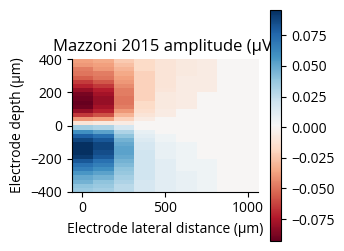

In [3]:
fig, ax = plt.subplots(figsize=(3, 3))
kwargs = dict(cmap="RdBu", extent=[-62.5, 1062.5, -400, 400])

im = ax.imshow(df.values[:, 1:], **kwargs)
fig.colorbar(im)
ax.set(
    title=f"Mazzoni 2015 amplitude (μV)",
    ylabel="Electrode depth (μm)",
    xlabel="Electrode lateral distance (μm)",
)

In [4]:
rng = np.random.default_rng()

d = np.linspace(-600, 600, 50, endpoint=True)
# d = np.linspace(-400, 400, 50, endpoint=True)
# d = np.linspace(-400, 400, 33, endpoint=True)
r = np.linspace(0, 1200, 20, endpoint=True)
# r = np.linspace(0, 1000, 20, endpoint=True)
# r = np.linspace(0, 1000, 9, endpoint=True)
rr, dd = np.meshgrid(r, d)

# for plotting
rstep = np.diff(r).mean()
dstep = np.diff(d).mean()
extent = [
    rr.min() - rstep / 2,
    rr.max() + rstep / 2,
    dd.min() - dstep / 2,
    dd.max() + dstep / 2,
]

## Aussel et al., 2018 cosine approximation

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Aussel 2018 amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

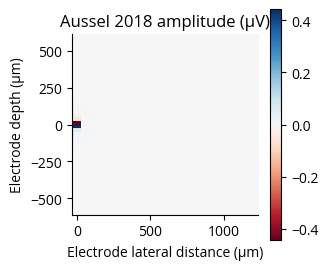

In [5]:
f_aussel = wslfp.aussel18(rr, dd)
wslfp.plot_amp(f_aussel, title="Aussel 2018 amplitude (μV)", extent=extent)

This doesn't match the original figure so well, but is this because this method is actually a principled derivation for a single neuron, as opposed to a measure for a whole population?
To find out, let's average the results over a 250 μm radius cylinder of randomly distributed neurons and see if it matches.

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Aussel 2018 population amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

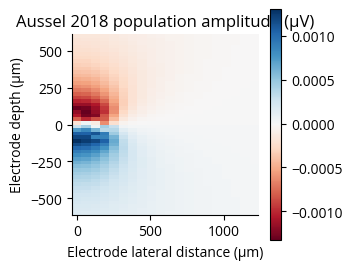

In [6]:
n = 4000
# center of neuron between -100 and 100 microns
nrns_somata = rng.uniform(-250, 0, n)
nrns_apex = rng.uniform(0, 250, n)
dd_neurons = (nrns_somata + nrns_apex) / 2
dd_pop = dd[..., np.newaxis] - dd_neurons
# neuron lengths between 100 and 400 microns
# L_pop = rng.uniform(100, 400, n)
L_pop = nrns_apex - nrns_somata
# horizontal distance: not simple. depends on r
rr_neurons = np.sqrt(rng.uniform(0, 250**2, n))
theta_neurons = rng.uniform(0, 2 * np.pi, n)
rr_pop = np.sqrt(
    (rr[..., np.newaxis] - rr_neurons * np.cos(theta_neurons)) ** 2
    + (rr_neurons * np.sin(theta_neurons)) ** 2
)

f_aussel_pop = wslfp.aussel18(rr_pop, dd_pop, L_pop).mean(axis=2)
wslfp.amplitude.plot_amp(
    f_aussel_pop, title="Aussel 2018 population amplitude (μV)", extent=extent
)

## Modified Aussel et al., 2018 cosine approximation

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Modified Aussel 2018 amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

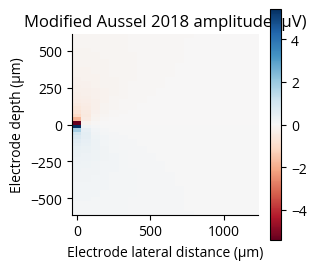

In [7]:
f_aussel_mod = wslfp.aussel18_mod(rr, dd)
wslfp.plot_amp(f_aussel_mod, title="Modified Aussel 2018 amplitude (μV)", extent=extent)

And the population version:

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Mod. Aussel 2018 population amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

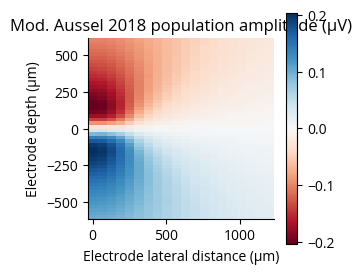

In [8]:
f_aussel_mod_pop = wslfp.aussel18_mod(rr_pop, dd_pop, L_pop).mean(axis=2)
wslfp.plot_amp(
    f_aussel_mod_pop, title="Mod. Aussel 2018 population amplitude (μV)", extent=extent
)

## Interpolated Mazzoni, Lindén et al., 2015 data

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Mazzoni 2015'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

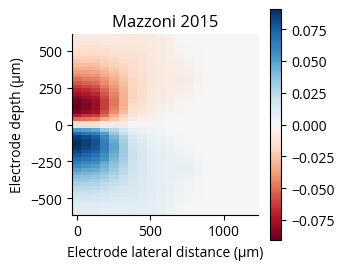

In [9]:
f_ml = wslfp.amplitude.f_amp(rr, dd, method="mazzoni15_pop")
wslfp.amplitude.plot_amp(f_ml, title="Mazzoni 2015", extent=extent)

## How different are the two?

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': '$\\tilde{f}_{aussel}-\\tilde{f}_{mazzoni}$'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

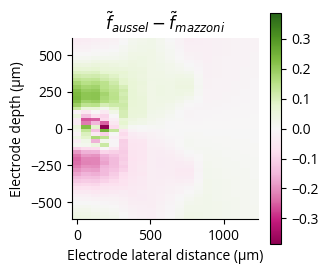

In [10]:
f_pop_norm = f_aussel_pop / f_aussel_pop.max()
f_ml_norm = f_ml / f_ml.max()
diff = f_pop_norm - f_ml_norm  # / f_norm * 100
wslfp.amplitude.plot_amp(
    diff,
    title=r"$\tilde{f}_{aussel}-\tilde{f}_{mazzoni}$",
    extent=extent,
    cmap="PiYG",
    vlim=np.max(np.abs(diff)),
)

## What does the Mazzoni profile look like for a population?
That is, if we take it as the profile of a single neuron, what happens after averaging over a population?

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Mazzoni 2015 population amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

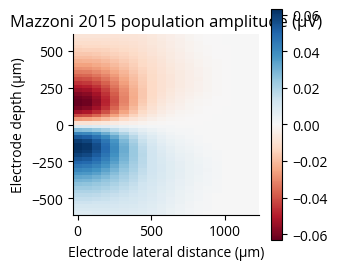

In [11]:
f_mazzoni_pop = wslfp.amplitude.f_amp(rr_pop, dd_pop, L_pop, "mazzoni15_pop").mean(
    axis=2
)
wslfp.amplitude.plot_amp(
    f_mazzoni_pop, title="Mazzoni 2015 population amplitude (μV)", extent=extent
)

## Can we shrink the per-neuron Mazzoni-Lindén profile so the population profile matches?

In [12]:
from scipy.optimize import minimize

f_ml_norm = f_ml / f_ml.max()


def f_opt(rscale_dscale):
    rscale, dscale = rscale_dscale
    f_pop = wslfp.mazzoni15_pop(rr_pop * rscale, dd_pop * dscale).mean(axis=2)
    f_pop_norm = f_pop / f_pop.max()
    loss = np.sum((f_pop_norm - f_ml_norm) ** 2)
    print(rscale_dscale, loss)
    return loss


opt_result = minimize(f_opt, [2, 2], bounds=[(1, 5), [1, 5]], method="L-BFGS-B")
rscale, dscale = opt_result.x
opt_result

[2. 2.] 6.46943502024212
[2.00000001 2.        ] 6.469435000107651
[2.         2.00000001] 6.4694351300516795
[4.01344693 1.        ] 15.86415177367493
[4.01344694 1.        ] 15.864151800342784
[4.01344693 1.00000001] 15.864151283412014
[2.74771868 1.6286375 ] 3.8758280266446565
[2.74771869 1.6286375 ] 3.875828044415491
[2.74771868 1.62863751] 3.875828063173214
[2.38855762 1.43906776] 2.8279780776422756
[2.38855763 1.43906776] 2.8279781040243033
[2.38855762 1.43906777] 2.82797806786321
[1. 1.] 3.344066504886742
[1.00000001 1.        ] 3.344066397077746
[1.         1.00000001] 3.344066318067447
[1.65486711 1.20707174] 1.244250127011448
[1.65486712 1.20707174] 1.2442501617060813
[1.65486711 1.20707175] 1.2442500664396412
[1. 1.] 3.344066504886742
[1.00000001 1.        ] 3.344066397077746
[1.         1.00000001] 3.344066318067447
[1.45791145 1.14479353] 1.0214892291219368
[1.45791146 1.14479353] 1.0214892599967835
[1.45791145 1.14479354] 1.0214891483430826
[1.         1.19937747] 1.68581

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.4947266853605271
        x: [ 1.298e+00  1.218e+00]
      nit: 12
      jac: [ 5.163e-06  9.637e-06]
     nfev: 51
     njev: 17
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [15]:
rscale, dscale

(1.2981118560519758, 1.2181074310330469)

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'LFP amplitude (μV)'}, xlabel='Electrode lateral distance (μm)', ylabel='Electrode depth (μm)'>)

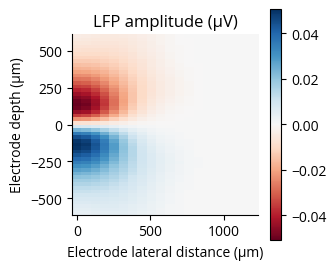

In [13]:
f_ml_shrink_pop = wslfp.mazzoni15_pop(rr_pop * rscale, dd_pop * dscale).mean(axis=2)
wslfp.amplitude.plot_amp(f_ml_shrink_pop, extent=extent)

## Summary figure
Here we'll visualize the different profiles directly and see how the `mazzoni15` profile shrunken down for individual neurons is best for capturing the population signal.

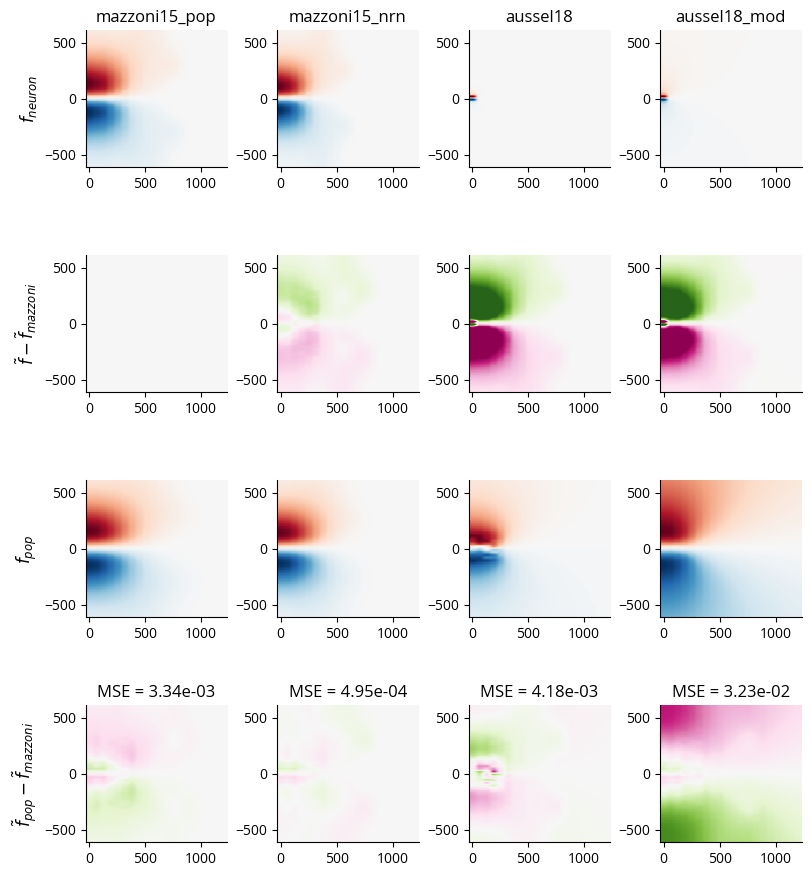

In [16]:
comparison_methods = ["mazzoni15_pop", "mazzoni15_nrn", "aussel18", "aussel18_mod"]
fig, axs = plt.subplots(
    4, len(comparison_methods), figsize=(8, 9), layout="constrained"
)
f_ml_norm = f_ml / f_ml.max()
# need to use same vlim to compare
vlim = 0.5
for method, axcol in zip(comparison_methods, axs.T):
    f = wslfp.amplitude.f_amp(rr, dd, method=method)
    wslfp.amplitude.plot_amp(
        f, title=method, extent=extent, cbar=False, labels=False, fig=fig, ax=axcol[0]
    )

    f_norm = f / f.max()
    f_norm = np.nan_to_num(f_norm)
    diff = f_norm - f_ml_norm  # / f_norm * 100
    wslfp.amplitude.plot_amp(
        diff,
        extent=extent,
        fig=fig,
        cmap="PiYG",
        cbar=False,
        labels=False,
        vlim=vlim,
        ax=axcol[1],
    )

    f_pop = wslfp.amplitude.f_amp(rr_pop, dd_pop, L_um=L_pop, method=method).mean(
        axis=2
    )
    wslfp.amplitude.plot_amp(
        f_pop,
        extent=extent,
        fig=fig,
        cbar=False,
        labels=False,
        ax=axcol[2],
    )

    f_pop_norm = f_pop / f_pop.max()
    diff_pop = f_pop_norm - f_ml_norm  # / f_norm * 100
    wslfp.amplitude.plot_amp(
        diff_pop,
        extent=extent,
        fig=fig,
        cmap="PiYG",
        cbar=False,
        vlim=vlim,
        labels=False,
        ax=axcol[3],
        title=f"MSE = {np.mean(diff_pop**2):.2e}",
    )

for ax, row_title in zip(
    axs[:, 0],
    [
        "$f_{neuron}$",
        r"$\tilde{f}-\tilde{f}_{mazzoni}$",
        "$f_{pop}$",
        r"$\tilde{f}_{pop}-\tilde{f}_{mazzoni}$",
    ],
):
    ax.set_ylabel(row_title, rotation=90, size="large")